In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,4)
from datetime import timedelta
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from sklearn.preprocessing import *
from sklearn.metrics import *
import seaborn as sns

In [22]:
dataframe = pd.read_csv("HUElec.csv")
HUElec = pd.melt(dataframe, id_vars=["Date"], var_name='time')
HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = HUElec.set_index('Datetime')
HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head(100)

,value
Datetime,
2010-01-25 00:00:00,0.000
2010-01-25 00:30:00,0.000
2010-01-25 01:00:00,0.000
2010-01-25 01:30:00,0.000
2010-01-25 02:00:00,0.000
...,...
2010-01-26 23:30:00,39.410
2010-01-27 00:00:00,40.800
2010-01-27 00:30:00,39.213


In [23]:
data = HUElec.copy()
df = data.resample(rule='h').sum()
df = df.rename(columns={'value':'load'})
df.head()

,load
Datetime,
2010-01-25 00:00:00,0.0
2010-01-25 01:00:00,0.0
2010-01-25 02:00:00,0.0
2010-01-25 03:00:00,0.0
2010-01-25 04:00:00,0.0


In [24]:
df.isna().sum()

load    0
dtype: int64

# Data Visualization

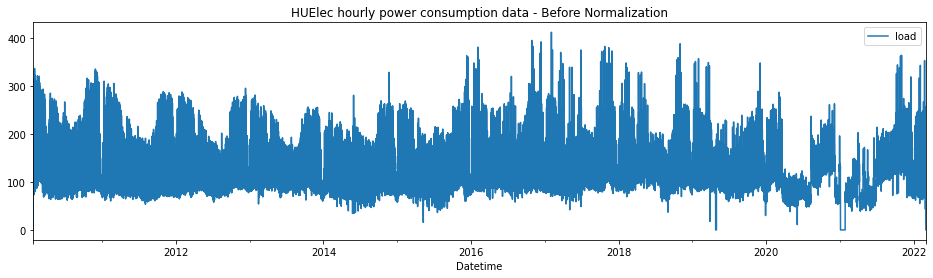

In [25]:
df.plot(legend=True)
plt.title('HUElec hourly power consumption data - Before Normalization')
plt.show()

# Normalize the Data

In [26]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['load']=scaler.fit_transform(df['load'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(106056, 1)

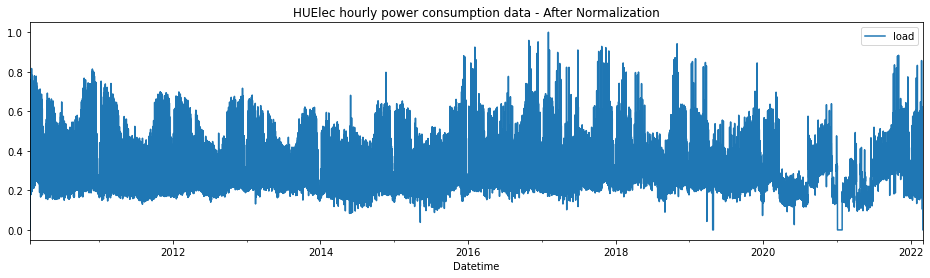

In [27]:
df.plot(legend=True)
plt.title('HUElec hourly power consumption data - After Normalization')
plt.show()

## Prepare data for training the LSTM Model

In [28]:
def load_data(df, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)):
        X_train.append(df.iloc[i-seq_len : i, 0])
        y_train.append(df.iloc[i, 0])
    
    #1 last 6056 days are going to be used in test
    X_test = X_train[100000:]             
    y_test = y_train[100000:]
    
    #2 first 100000 days are going to be used in training
    X_train = X_train[:100000]           
    y_train = y_train[:100000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (100000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [29]:
#create train, test data
seq_len = 24 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (100000, 24, 1)
y_train.shape =  (100000,)
X_test.shape =  (6032, 24, 1)
y_test.shape =  (6032,)


### Build LSTM Model

In [30]:
lstm_model = Sequential()

lstm_model.add(LSTM(64,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(64,activation="relu",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(64,activation="relu",return_sequences=False))
lstm_model.add(Dropout(0.2))

# lstm_model.add(Dense(8))

lstm_model.add(Dense(1))

lstm_model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_3/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
ES = EarlyStopping(monitor='val_loss', patience=2)
lstm_model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=1000, callbacks=[ES], shuffle=False)

Epoch 1/30
90/90 [==============================] - 46s 303ms/step - loss: 0.0512 - val_loss: 0.0073
Epoch 2/30
90/90 [==============================] - 24s 261ms/step - loss: 0.0209 - val_loss: 0.0120
Epoch 3/30
90/90 [==============================] - 23s 261ms/step - loss: 0.0151 - val_loss: 0.0065
Epoch 4/30
90/90 [==============================] - 23s 254ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 5/30
90/90 [==============================] - 23s 261ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 6/30
90/90 [==============================] - 22s 249ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 7/30
90/90 [==============================] - 23s 251ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 8/30
90/90 [==============================] - 23s 251ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 9/30
90/90 [==============================] - 23s 252ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/30
90/90 [==============================] - 23s 250ms/step - loss: 0.0035 - val_lo

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score*100)

R^2 Score of LSTM model =  79.14419174860082


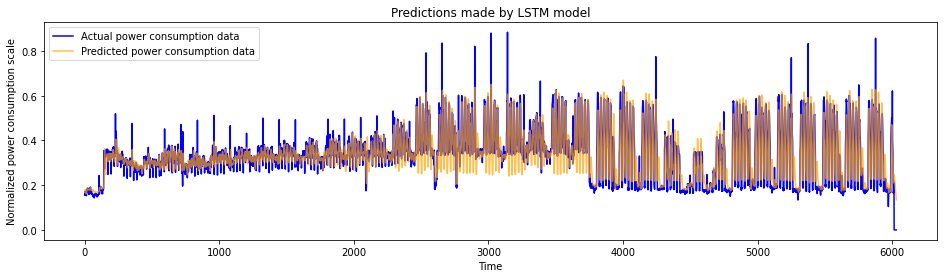

In [ ]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

# XGBoost

# FB Prophet

# LightGBM

# Baseline